In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import spacy

import gensim
from gensim import corpora

import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

from sklearn.decomposition import LatentDirichletAllocation


In [21]:
import pyLDAvis.gensim_models

https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

In [4]:
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 
review_data=filtered_data

In [5]:
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
40000
Unique Products
5266
Unique Users
33300


In [6]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [7]:
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dtewani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]

df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=1000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))



#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
5    27181
4     6258
1     4109
2     2452
Name: Score, dtype: int64
40000
-------------------------
No of Short reviews
26355


In [9]:
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

In [10]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [11]:
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [12]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

good product especially iced coffee twice price stores isnt flukewithin past months bought seattle nevada looks like good oldfashioned gouging harder amazon
['good', 'product', 'iced', 'coffee', 'twice', 'price', 'store', 'flukewithin', 'past', 'month', 'good', 'oldfashioned', 'gouging', 'hard']


# Create vocabulary dictionary and document term matrix

In [13]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [18]:
doc_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1),
  (4, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1)],
 [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)],
 [(10, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 3),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1)],
 [(4, 3),
  (10, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2)],
 [(14, 1),
  (33, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1)],
 [(12, 1),
  (45, 3),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1)],
 [(0, 1),
  (19, 1),
  (64, 1

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [16]:
lda_model.print_topics()

[(0,
  '0.023*"date" + 0.014*"expiration" + 0.011*"stock" + 0.010*"hole" + 0.009*"package" + 0.009*"trip" + 0.008*"hard" + 0.008*"little" + 0.007*"plastic" + 0.007*"roll"'),
 (1,
  '0.028*"product" + 0.020*"chicken" + 0.018*"great" + 0.017*"dog" + 0.015*"treat" + 0.014*"small" + 0.012*"time" + 0.011*"good" + 0.011*"size" + 0.009*"large"'),
 (2,
  '0.029*"product" + 0.025*"sugar" + 0.022*"milk" + 0.021*"flavor" + 0.017*"good" + 0.014*"vanilla" + 0.012*"taste" + 0.012*"organic" + 0.012*"noodle" + 0.012*"sauce"'),
 (3,
  '0.027*"product" + 0.022*"store" + 0.018*"good" + 0.014*"can" + 0.013*"price" + 0.012*"time" + 0.012*"butter" + 0.012*"taste" + 0.011*"peanut" + 0.011*"food"'),
 (4,
  '0.033*"popcorn" + 0.018*"kcup" + 0.016*"weak" + 0.014*"good" + 0.014*"product" + 0.011*"great" + 0.010*"small" + 0.010*"medium" + 0.009*"greenie" + 0.009*"large"'),
 (5,
  '0.030*"drink" + 0.026*"juice" + 0.025*"flavor" + 0.020*"sugar" + 0.018*"taste" + 0.018*"sweet" + 0.017*"fruit" + 0.016*"water" + 0.014

In [25]:
import pyLDAvis.gensim as gensimvis

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

In [26]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.

.gensim.prepare(lda_model, doc_term_matrix, dictionary)
#vis

In [29]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.3474950021170065

Coherence Score:  0.41271567080558247


In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)


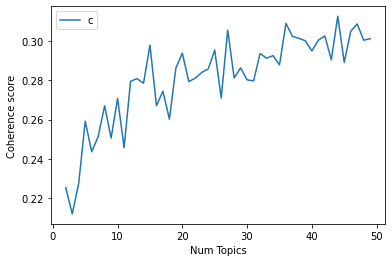

In [32]:
#Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))



Num Topics = 2  has Coherence Value of 0.2251
Num Topics = 3  has Coherence Value of 0.2118
Num Topics = 4  has Coherence Value of 0.2276
Num Topics = 5  has Coherence Value of 0.2592
Num Topics = 6  has Coherence Value of 0.2436
Num Topics = 7  has Coherence Value of 0.2514
Num Topics = 8  has Coherence Value of 0.2671
Num Topics = 9  has Coherence Value of 0.2506
Num Topics = 10  has Coherence Value of 0.2708
Num Topics = 11  has Coherence Value of 0.2456
Num Topics = 12  has Coherence Value of 0.2796
Num Topics = 13  has Coherence Value of 0.281
Num Topics = 14  has Coherence Value of 0.2786
Num Topics = 15  has Coherence Value of 0.2981
Num Topics = 16  has Coherence Value of 0.2671
Num Topics = 17  has Coherence Value of 0.2745
Num Topics = 18  has Coherence Value of 0.2602
Num Topics = 19  has Coherence Value of 0.2863
Num Topics = 20  has Coherence Value of 0.294
Num Topics = 21  has Coherence Value of 0.2794
Num Topics = 22  has Coherence Value of 0.2812
Num Topics = 23  has Co

In [34]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)


[(0,
  '0.032*"flavor" + 0.019*"good" + 0.015*"chip" + 0.015*"chocolate" + 0.012*"snack" + 0.012*"sugar" + 0.011*"product" + 0.011*"juice" + 0.010*"calorie" + 0.009*"taste"'),
 (1,
  '0.019*"product" + 0.016*"good" + 0.014*"great" + 0.011*"time" + 0.010*"flavor" + 0.010*"coffee" + 0.009*"store" + 0.008*"review" + 0.007*"year" + 0.007*"food"'),
 (2,
  '0.062*"coffee" + 0.028*"good" + 0.023*"flavor" + 0.020*"great" + 0.014*"taste" + 0.009*"food" + 0.009*"chip" + 0.009*"little" + 0.009*"time" + 0.008*"price"'),
 (3,
  '0.027*"good" + 0.015*"popcorn" + 0.014*"chip" + 0.011*"sugar" + 0.010*"taste" + 0.009*"product" + 0.009*"time" + 0.008*"small" + 0.008*"coffee" + 0.008*"drink"'),
 (4,
  '0.021*"good" + 0.020*"flavor" + 0.019*"taste" + 0.015*"product" + 0.015*"great" + 0.011*"price" + 0.011*"food" + 0.008*"favorite" + 0.007*"time" + 0.006*"year"'),
 (5,
  '0.018*"food" + 0.016*"good" + 0.014*"product" + 0.012*"treat" + 0.011*"chocolate" + 0.011*"taste" + 0.009*"dog" + 0.008*"time" + 0.007*"

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis